<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Capstone Project: 2.2 Modelling - Age Group Classification

> Authors: Pius Yee

##### In this Notebook 2.2, I will proceed to build the model for Age Group classification.

### Import libraries

In [26]:
import os
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.image import imread
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras
from keras_vggface.vggface import VGGFace
from keras.applications.resnet import ResNet50

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, auc, classification_report 
from sklearn.preprocessing import LabelEncoder


## 1. Importing images for model training

In [4]:
# Import dataframe from the previous notebook

df_main = pd.read_csv("../datasets/df_main.csv",index_col=0)
df_main.head()

,filename,age,gender,race,age_range
0,9_1_2_20161219204347420.jpg.chip.jpg,9,Female,Asian,0-10
1,36_0_1_20170117163203851.jpg.chip.jpg,36,Male,Black,31-40
2,86_1_0_20170120225751953.jpg.chip.jpg,86,Female,White,71-120
3,26_1_0_20170116171048641.jpg.chip.jpg,26,Female,White,21-30
4,1_1_2_20161219154612988.jpg.chip.jpg,1,Female,Asian,0-10


##### Similar to the previous model for gender prediction, I will manually create a new column for train-test splitting in the dataframe instead of using the train-test split library. The reason for this approach is that I will use the flow-from-dataframe method to import images, making it easier to manually split the train and test data.

In [5]:
# Manually create a train-test split column in the dataframe, with 80% for train and 20% for test.
np.random.seed(39)
df_main['train_test'] = np.random.choice([0, 1], size=len(df_main), p=[0.8,0.2],)
df_main

,filename,age,gender,race,age_range,train_test
0,9_1_2_20161219204347420.jpg.chip.jpg,9,Female,Asian,0-10,0
1,36_0_1_20170117163203851.jpg.chip.jpg,36,Male,Black,31-40,0
2,86_1_0_20170120225751953.jpg.chip.jpg,86,Female,White,71-120,1
3,26_1_0_20170116171048641.jpg.chip.jpg,26,Female,White,21-30,0
4,1_1_2_20161219154612988.jpg.chip.jpg,1,Female,Asian,0-10,0
...,...,...,...,...,...,...
23702,35_0_0_20170117155112202.jpg.chip.jpg,35,Male,White,31-40,0
23703,52_0_3_20170119200211340.jpg.chip.jpg,52,Male,Indian,51-60,0
23704,26_0_1_20170116010114628.jpg.chip.jpg,26,Male,Black,21-30,1
23705,28_0_1_20170117015458481.jpg.chip.jpg,28,Male,Black,21-30,1


##### For importing the images, I will use ImageDataGenerator from Keras. It not only help to rescale the training images, but also do augmentation for the images.

##### In this case, I used the following augmentations:

- `width_shift_range=0.2:` Randomly shifts the image horizontally along the width by up to 20% of the total width, enhancing model robustness to object position variations.

- `height_shift_range=0.2:` Randomly shifts the image vertically along the height by up to 20% of the total height, similar to the width shift but in the vertical direction.

- `shear_range=0.2:` Applies a shear transformation, slanting the image along one axis, helping simulate perspective changes.

- `zoom_range=0.2:` Randomly zooms the image in or out by up to 20%, making the model more resilient to changes in the object's apparent size.

- `horizontal_flip=True:` Randomly flips the image horizontally (like looking in a mirror), helping prevent the model from developing biases based on left/right orientation.

- `fill_mode='nearest':` Specifies how to fill in newly created pixels at the image edges after transformations (shifts, shears, etc.), using the nearest pixel value to preserve the image's overall structure.

In [7]:
# Create an ImageDataGenerator for training images (with augmentation)
datagen_train = ImageDataGenerator(   # for train data
        rescale=1.0/255.0,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# Create an ImageDataGenerator for validation images (without augmentation)
datagen_val = ImageDataGenerator(   # for test data
        rescale=1.0/255.0)

##### Import the images with the newly created ImageDataGenerator

In [8]:
# Set up your data flow using flow_from_dataframe
train_data = datagen_train.flow_from_dataframe(
    dataframe=df_main[df_main.train_test == 0],
    directory='../datasets/utkface',
    x_col='filename',
    y_col='age_range',
    target_size=(224,224),
    class_mode='categorical')  # Use 'raw' for multi-output models

val_data = datagen_val.flow_from_dataframe(
    dataframe=df_main[df_main.train_test == 1],
    directory='../datasets/utkface',
    x_col='filename',
    y_col='age_range',
    target_size=(224,224),
    class_mode='categorical')  # Use 'raw' for multi-output models

Found 18981 validated image filenames belonging to 8 classes.
Found 4726 validated image filenames belonging to 8 classes.


The data consists of 8 classes of age group:

In [9]:
# check the classes for imported data
train_data.class_indices

{'0-10': 0,
 '11-20': 1,
 '21-30': 2,
 '31-40': 3,
 '41-50': 4,
 '51-60': 5,
 '61-70': 6,
 '71-120': 7}

## 2. Setting up the models

For the models, I will use 3 different models as baselines to determine which one yields the best result. I will then select the best-performing model for further tuning.

The 3 models are:
- Keras CNN (without pre-trained model)
- VGGFace
- ResNet

### 2.1 Keras CNN (without pre-trained model)

##### Setting up the model architecture

In [10]:
model_cnn = Sequential()

# Add a convolutional layer to the instantiated empty model.
# Conv2D for 2-D convolution on image
model_cnn.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))

# EVERY convolution layer is followed by a pooling layer.
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

# more layers
model_cnn.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

# Add some fully connected layers once we have 1-D vector from 'Flatten()'
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(8, activation='softmax')) # Output layer

# show the summary
model_cnn.summary()

2024-05-03 01:00:06.339627: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-03 01:00:06.340127: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-05-03 01:00:06.340522: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-05-03 01:00:06.340786: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-03 01:00:06.341001: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 128)               1

In [11]:
# Compile model.
opt = Adam(learning_rate=0.001) # create Adam optimizer with 1e-3 learning rate
model_cnn.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [12]:
# Fit model on training data (fit model and save results to history)
history_cnn = model_cnn.fit(train_data, # train_data created using ImageDataGenerator class for model training
                        batch_size=64, 
                        validation_data=val_data, # val_data created using ImageDataGenerator class for model validation
                        epochs=5, 
                       )

Epoch 1/5


2024-05-03 01:00:09.159775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


594/594 [==============================] - 332s 548ms/step - loss: 2.1085 - accuracy: 0.3021 - val_loss: 1.8996 - val_accuracy: 0.3295
Epoch 2/5
594/594 [==============================] - 312s 524ms/step - loss: 1.9013 - accuracy: 0.3247 - val_loss: 1.9379 - val_accuracy: 0.3320
Epoch 3/5
594/594 [==============================] - 302s 507ms/step - loss: 2.0731 - accuracy: 0.3007 - val_loss: 1.9171 - val_accuracy: 0.3373
Epoch 4/5
594/594 [==============================] - 286s 481ms/step - loss: 2.9154 - accuracy: 0.2847 - val_loss: 2.0544 - val_accuracy: 0.2581
Epoch 5/5
594/594 [==============================] - 298s 500ms/step - loss: 2.6275 - accuracy: 0.2793 - val_loss: 2.2626 - val_accuracy: 0.3070


##### The results are as follows:-

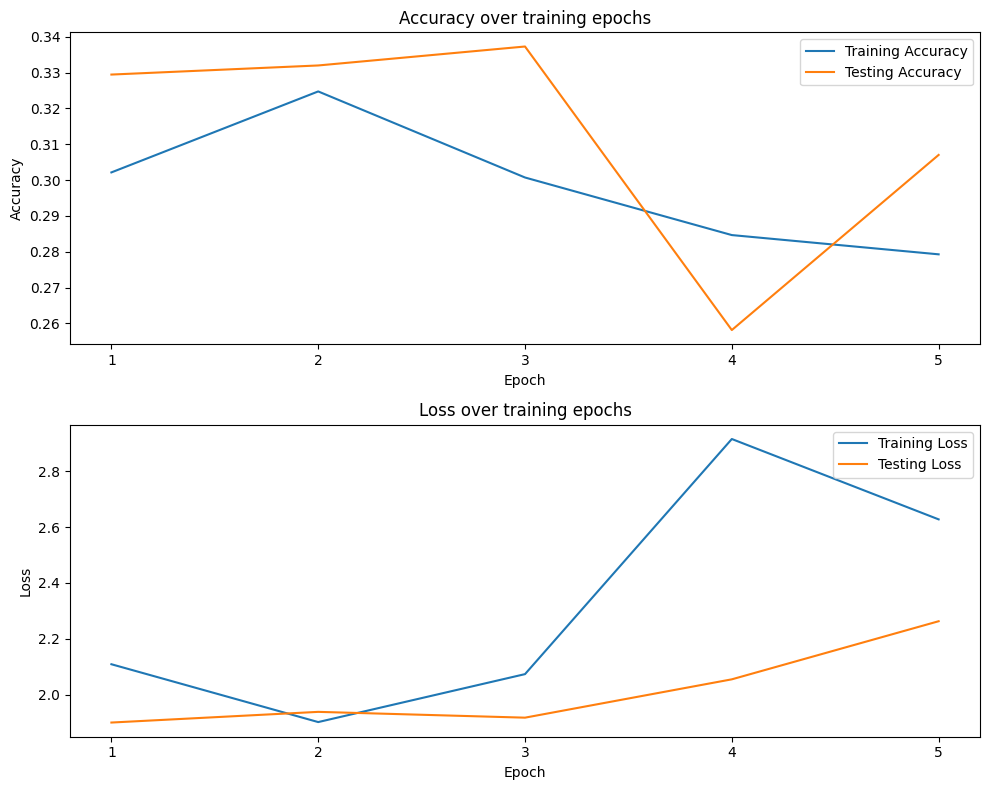

In [102]:
# Check out our train loss and test loss over epochs.
train_loss_cnn = history_cnn.history['loss']
test_loss_cnn = history_cnn.history['val_loss']
train_acc_cnn = history_cnn.history['accuracy']
test_acc_cnn = history_cnn.history['val_accuracy']

# Set figure size.
fig, axes = plt.subplots(nrows=2, figsize=(10,8))

# Generate line plot of training, testing loss over epochs.
axes[0].plot(train_acc_cnn, label='Training Accuracy')
axes[0].plot(test_acc_cnn, label='Testing Accuracy')
axes[0].set_title("Accuracy over training epochs")
axes[0].legend();
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(np.arange(len(test_acc_cnn)), np.arange(1, len(test_acc_cnn)+1))

axes[1].plot(train_loss_cnn, label='Training Loss')
axes[1].plot(test_loss_cnn, label='Testing Loss')
axes[1].set_title("Loss over training epochs")
axes[1].legend();
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_xticks(np.arange(len(test_acc_cnn)), np.arange(1, len(test_acc_cnn)+1))

# Set title
plt.tight_layout()
plt.show()

### 2.2 VGGFace (Transfer learning from Pre-trained model)

##### Import the pre-trained model

In [14]:
# Import the desired pre-trained transfer learning model: VGGFace
pre_trained_vgg = VGGFace(model='vgg16', include_top=False, input_shape=(224,224,3))

# Freeze the model so we don't accidentally change the pre-trained model parameters during dense layer gradient descent
for layer in pre_trained_vgg.layers:
  layer.trainable = False

##### Setting up the model architecture

In [15]:
model_vgg = Sequential()

# Add the pretrained mdoel
model_vgg.add(pre_trained_vgg)

# Flatten the pre-trained output
model_vgg.add(Flatten())

# Add dense layers
model_vgg.add(Dense(128, activation='relu'))
model_vgg.add(Dense(64, activation='relu'))
model_vgg.add(Dense(8, activation='softmax')) # Output layer

# show the summary
model_vgg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vggface_vgg16 (Functional)  (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 128)               3211392   
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 8)                 520       
                                                                 
Total params: 17,934,856
Trainable params: 3,220,168
Non-trainable params: 14,714,688
_________________________________________________________________


In [16]:
# Compile model.
opt = Adam(learning_rate=0.001) # create Adam optimizer with 1e-3 learning rate
model_vgg.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [17]:
# Fit model on training data (fit model and save results to history)
history_vgg = model_vgg.fit(train_data, # train_data created using ImageDataGenerator class for model training
                        batch_size=64, 
                        validation_data=val_data, # val_data created using ImageDataGenerator class for model validation
                        epochs=5, 
                       )

Epoch 1/5
594/594 [==============================] - 1007s 2s/step - loss: 1.1340 - accuracy: 0.5525 - val_loss: 1.1074 - val_accuracy: 0.5855
Epoch 2/5
594/594 [==============================] - 954s 2s/step - loss: 1.0304 - accuracy: 0.5793 - val_loss: 0.9712 - val_accuracy: 0.5978
Epoch 3/5
594/594 [==============================] - 952s 2s/step - loss: 1.0275 - accuracy: 0.5824 - val_loss: 1.0305 - val_accuracy: 0.5925
Epoch 4/5
594/594 [==============================] - 970s 2s/step - loss: 1.0382 - accuracy: 0.5825 - val_loss: 1.0011 - val_accuracy: 0.6096
Epoch 5/5
594/594 [==============================] - 990s 2s/step - loss: 1.0158 - accuracy: 0.5883 - val_loss: 1.1125 - val_accuracy: 0.5286


##### The results are as follows:-

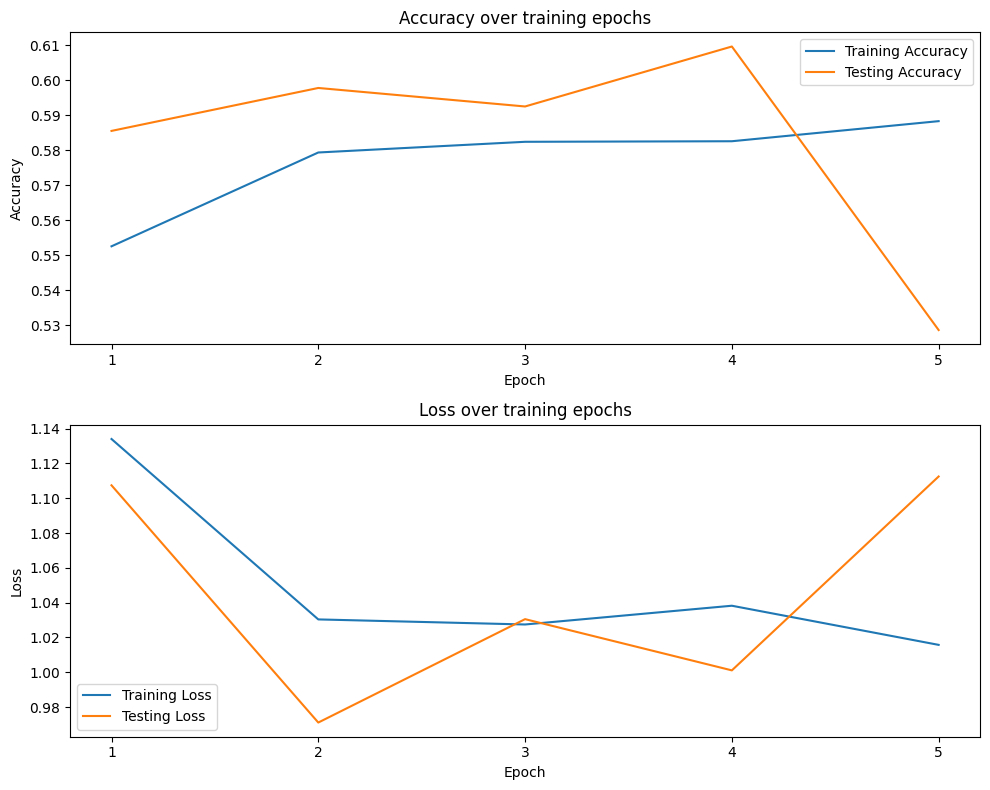

In [103]:
# Check out our train loss and test loss over epochs.
train_loss_vgg = history_vgg.history['loss']
test_loss_vgg = history_vgg.history['val_loss']
train_acc_vgg = history_vgg.history['accuracy']
test_acc_vgg = history_vgg.history['val_accuracy']

# Set figure size.
fig, axes = plt.subplots(nrows=2, figsize=(10,8))

# Generate line plot of training, testing loss over epochs.
axes[0].plot(train_acc_vgg, label='Training Accuracy')
axes[0].plot(test_acc_vgg, label='Testing Accuracy')
axes[0].set_title("Accuracy over training epochs")
axes[0].legend();
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(np.arange(len(test_acc_vgg)), np.arange(1, len(test_acc_vgg)+1))

axes[1].plot(train_loss_vgg, label='Training Loss')
axes[1].plot(test_loss_vgg, label='Testing Loss')
axes[1].set_title("Loss over training epochs")
axes[1].legend();
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_xticks(np.arange(len(test_acc_vgg)), np.arange(1, len(test_acc_vgg)+1))

# Set title
plt.tight_layout()
plt.show()

### 2.3 ResNet50 (Transfer learning from Pre-trained model)

##### Import the pre-trained model

In [19]:
# Import the desired pre-trained transfer learning model: VGGFace
pre_trained_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze the model so we don't accidentally change the pre-trained model parameters during dense layer gradient descent
for layer in pre_trained_resnet.layers:
  layer.trainable = False

##### Setting  up the model architecture

In [20]:
model_resnet = Sequential()

# Add the pretrained mdoel
model_resnet.add(pre_trained_resnet)

# Flatten the pre-trained output
model_resnet.add(Flatten())

# Add dense layers
model_resnet.add(Dense(128, activation='relu'))
model_resnet.add(Dense(64, activation='relu'))
model_resnet.add(Dense(8, activation='softmax')) # Output layer

# show the summary
model_resnet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_6 (Dense)             (None, 128)               12845184  
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 8)                 520       
                                                                 
Total params: 36,441,672
Trainable params: 12,853,960
Non-trainable params: 23,587,712
_________________________________________________________________


In [21]:
# Compile model.
opt = Adam(learning_rate=0.001) # create Adam optimizer with 1e-3 learning rate
model_resnet.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [22]:
# Fit model on training data (fit model and save results to history)
history_resnet = model_resnet.fit(train_data, # train_data created using ImageDataGenerator class for model training
                        batch_size=64, 
                        validation_data=val_data, # val_data created using ImageDataGenerator class for model validation
                        epochs=5, 
                       )

Epoch 1/5
594/594 [==============================] - 640s 1s/step - loss: 4.7291 - accuracy: 0.2171 - val_loss: 3.0271 - val_accuracy: 0.2484
Epoch 2/5
594/594 [==============================] - 643s 1s/step - loss: 3.6243 - accuracy: 0.2223 - val_loss: 2.1332 - val_accuracy: 0.2909
Epoch 3/5
594/594 [==============================] - 636s 1s/step - loss: 3.2737 - accuracy: 0.2331 - val_loss: 2.2129 - val_accuracy: 0.1377
Epoch 4/5
594/594 [==============================] - 645s 1s/step - loss: 3.4400 - accuracy: 0.2252 - val_loss: 2.4372 - val_accuracy: 0.3299
Epoch 5/5
594/594 [==============================] - 646s 1s/step - loss: 2.6919 - accuracy: 0.2476 - val_loss: 2.1761 - val_accuracy: 0.3322


##### The results are as follows:-

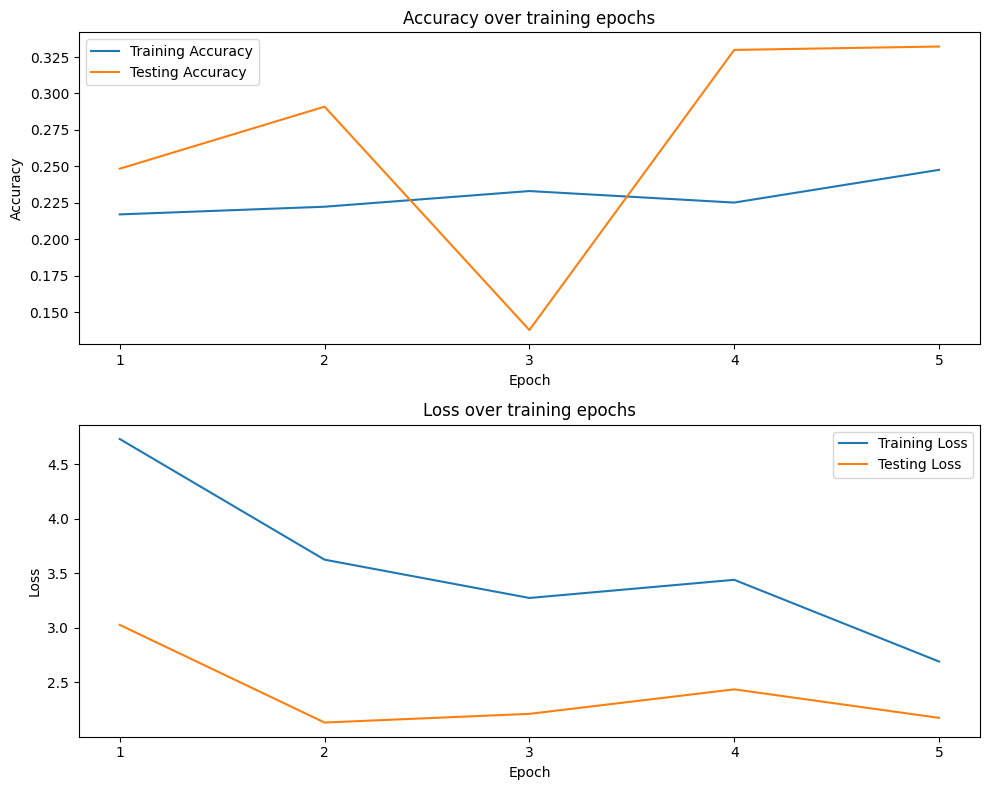

In [104]:
# Check out our train loss and test loss over epochs.
train_loss_resnet = history_resnet.history['loss']
test_loss_resnet = history_resnet.history['val_loss']
train_acc_resnet = history_resnet.history['accuracy']
test_acc_resnet = history_resnet.history['val_accuracy']

# Set figure size.
fig, axes = plt.subplots(nrows=2, figsize=(10,8))

# Generate line plot of training, testing loss over epochs.
axes[0].plot(train_acc_resnet, label='Training Accuracy')
axes[0].plot(test_acc_resnet, label='Testing Accuracy')
axes[0].set_title("Accuracy over training epochs")
axes[0].legend();
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(np.arange(len(test_acc_resnet)), np.arange(1, len(test_acc_resnet)+1))

axes[1].plot(train_loss_resnet, label='Training Loss')
axes[1].plot(test_loss_resnet, label='Testing Loss')
axes[1].set_title("Loss over training epochs")
axes[1].legend();
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_xticks(np.arange(len(test_acc_resnet)), np.arange(1, len(test_acc_resnet)+1))

# Set title
plt.tight_layout()
plt.show()

### 2.4 Evaluation of base models

##### The results for baseline models are:

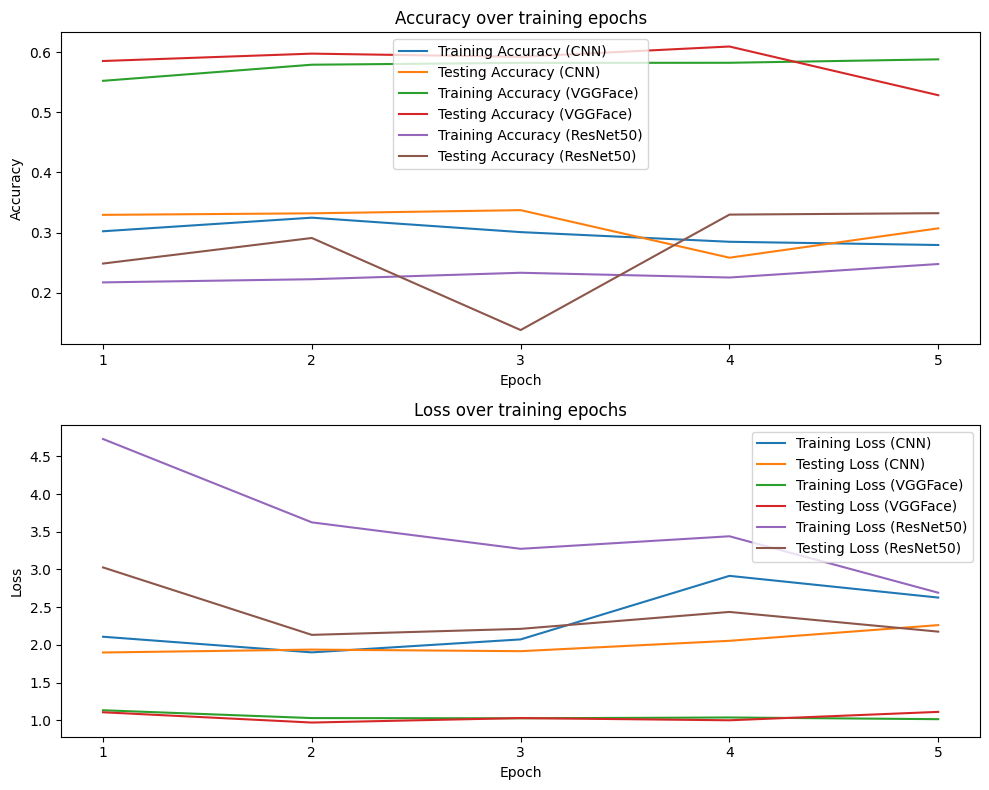

In [105]:
# Set figure size.
fig, axes = plt.subplots(nrows=2, figsize=(10,8))

# Generate line plot of training, testing loss over epochs.
# Accuracy
axes[0].plot(train_acc_cnn, label='Training Accuracy (CNN)')
axes[0].plot(test_acc_cnn, label='Testing Accuracy (CNN)')
axes[0].plot(train_acc_vgg, label='Training Accuracy (VGGFace)')
axes[0].plot(test_acc_vgg, label='Testing Accuracy (VGGFace)')
axes[0].plot(train_acc_resnet, label='Training Accuracy (ResNet50)')
axes[0].plot(test_acc_resnet, label='Testing Accuracy (ResNet50)')

axes[0].set_title("Accuracy over training epochs")
axes[0].legend();
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(np.arange(len(test_acc_vgg)), np.arange(1, len(test_acc_vgg)+1))

# Loss
axes[1].plot(train_loss_cnn, label='Training Loss (CNN)')
axes[1].plot(test_loss_cnn, label='Testing Loss (CNN)')
axes[1].plot(train_loss_vgg, label='Training Loss (VGGFace)')
axes[1].plot(test_loss_vgg, label='Testing Loss (VGGFace)')
axes[1].plot(train_loss_resnet, label='Training Loss (ResNet50)')
axes[1].plot(test_loss_resnet, label='Testing Loss (ResNet50)')

axes[1].set_title("Loss over training epochs")
axes[1].legend();
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_xticks(np.arange(len(test_acc_vgg)), np.arange(1, len(test_acc_vgg)+1))

# Set title
plt.tight_layout()
plt.show()

##### Based on the results above, VGGFace performed the best in both accuracy and loss. It has the highest accuracy and lowest loss.

##### In view of this, it is chosen to further tuning.

## 3. Hyperparameter tuning - VGGFace

##### I tried many different parameters to tune the VGGFace model for better performance.

##### The following is the best performance:
- Using regularisation like dropout and batch normalization
- more epochs with early stopping

In [27]:
# Create our FNN model architecture
model_vgg_opt = Sequential()

# Add the pre-trained model (VGGFace)
model_vgg_opt.add(pre_trained_vgg)

# Flatten the output
model_vgg_opt.add(Flatten())

# Add dense layers with batch normalization before activation functions and dropout
model_vgg_opt.add(Dense(128))
model_vgg_opt.add(BatchNormalization())
model_vgg_opt.add(Activation('relu'))
model_vgg_opt.add(Dropout(0.5))  # Add dropout with rate 0.5

model_vgg_opt.add(Dense(64))
model_vgg_opt.add(BatchNormalization())
model_vgg_opt.add(Activation('relu'))
model_vgg_opt.add(Dropout(0.5))  # Add dropout with rate 0.5

# Output layer for classification
model_vgg_opt.add(Dense(8, activation='softmax'))

model_vgg_opt.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vggface_vgg16 (Functional)  (None, 7, 7, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 dense_10 (Dense)            (None, 128)               3211392   
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                      

In [28]:
# Instantiating EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0,
                           patience=5,
                           mode='auto')

In [29]:
# Compile the model (same as what we've been doing before)
opt = Adam(learning_rate=0.001) # specify Adam optimizer
model_vgg_opt.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) # (same as what we've been doing before)

In [30]:
# Fit model on training data (fit model and save results to history)
history_vgg_opt = model_vgg_opt.fit(train_data, # train_data created using ImageDataGenerator class for model training (X, y split internally)
                        batch_size=32,
                        validation_data=val_data, # val_data created using ImageDataGenerator class for model validation (X, y split internally)
                        epochs=30,
                        callbacks=[early_stop] # Adding early stopping
                       )

Epoch 1/30
594/594 [==============================] - 406s 679ms/step - loss: 1.3822 - accuracy: 0.4812 - val_loss: 1.0493 - val_accuracy: 0.5857
Epoch 2/30
594/594 [==============================] - 464s 780ms/step - loss: 1.1285 - accuracy: 0.5507 - val_loss: 0.9481 - val_accuracy: 0.6151
Epoch 3/30
594/594 [==============================] - 438s 737ms/step - loss: 1.0785 - accuracy: 0.5654 - val_loss: 0.9482 - val_accuracy: 0.6132
Epoch 4/30
594/594 [==============================] - 434s 730ms/step - loss: 1.0518 - accuracy: 0.5773 - val_loss: 0.9400 - val_accuracy: 0.6140
Epoch 5/30
594/594 [==============================] - 438s 737ms/step - loss: 1.0350 - accuracy: 0.5770 - val_loss: 0.9301 - val_accuracy: 0.6185
Epoch 6/30
594/594 [==============================] - 433s 729ms/step - loss: 1.0211 - accuracy: 0.5857 - val_loss: 0.9195 - val_accuracy: 0.6223
Epoch 7/30
594/594 [==============================] - 468s 787ms/step - loss: 1.0168 - accuracy: 0.5821 - val_loss: 0.9267 -

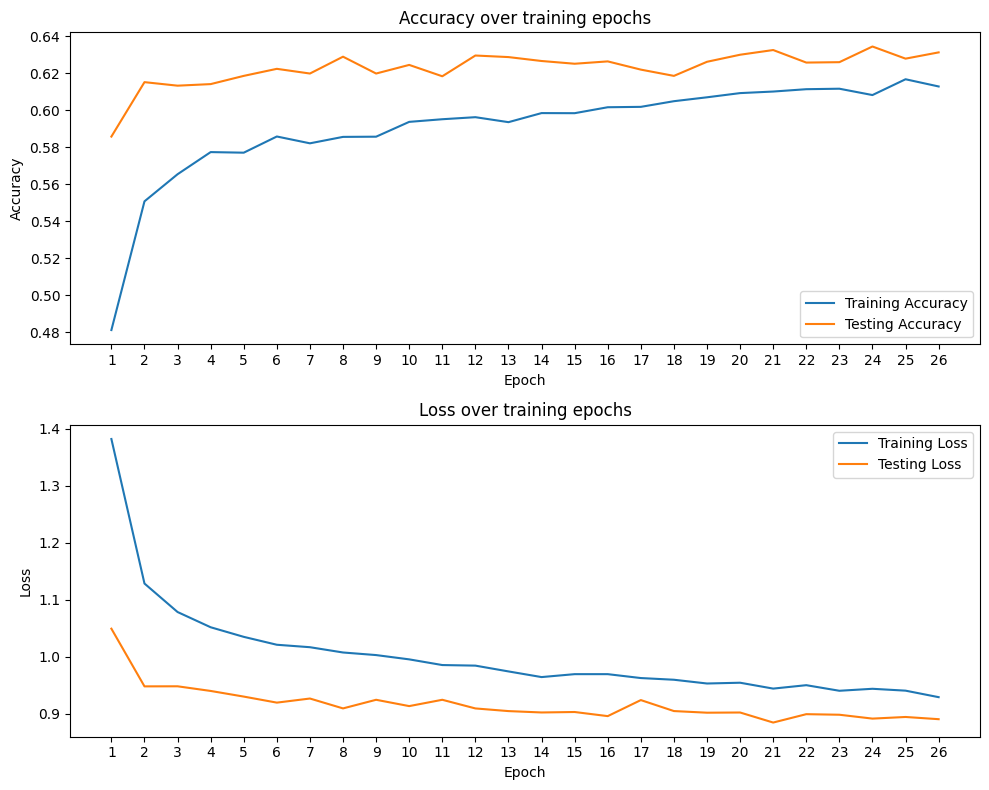

In [106]:
# Check out our train loss and test loss over epochs.
train_loss_vgg_opt = history_vgg_opt.history['loss']
test_loss_vgg_opt = history_vgg_opt.history['val_loss']
train_acc_vgg_opt = history_vgg_opt.history['accuracy']
test_acc_vgg_opt = history_vgg_opt.history['val_accuracy']

# Set figure size.
fig, axes = plt.subplots(nrows=2, figsize=(10,8))

# Generate line plot of training, testing loss over epochs.
axes[0].plot(train_acc_vgg_opt, label='Training Accuracy')
axes[0].plot(test_acc_vgg_opt, label='Testing Accuracy')
axes[0].set_title("Accuracy over training epochs")
axes[0].legend();
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(np.arange(len(test_acc_vgg_opt)), np.arange(1, len(test_acc_vgg_opt)+1))

axes[1].plot(train_loss_vgg_opt, label='Training Loss')
axes[1].plot(test_loss_vgg_opt, label='Testing Loss')
axes[1].set_title("Loss over training epochs")
axes[1].legend();
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_xticks(np.arange(len(test_acc_vgg_opt)), np.arange(1, len(test_acc_vgg_opt)+1))

# Set title
plt.tight_layout()
plt.show()

##### Based on the result above, early stopping kicked in at 26th epoch. The result after tuning is better. I will compare the result below.

---

##### Save the models before proceeding to the next section

In [40]:
# save the history records
plot_data = []
for model in ['cnn','vgg','resnet','vgg_opt']:
    for metric in ['train_loss_','test_loss_','train_acc_','test_acc_']:
        plot_data.append(metric+model)

df_history = pd.DataFrame({'name':plot_data,'history':[globals()[x] for x in plot_data]})
df_history.to_csv("../models/df_history_age.csv")
df_history


,name,history
0,train_loss_cnn,"[2.108501434326172, 1.90131413936615, 2.073063..."
1,test_loss_cnn,"[1.899609923362732, 1.9378806352615356, 1.9170..."
2,train_acc_cnn,"[0.30214425921440125, 0.3247458040714264, 0.30..."
3,test_acc_cnn,"[0.32945409417152405, 0.3319932222366333, 0.33..."
4,train_loss_vgg,"[1.1339951753616333, 1.0303844213485718, 1.027..."
5,test_loss_vgg,"[1.1074055433273315, 0.9711532592773438, 1.030..."
6,train_acc_vgg,"[0.5524998903274536, 0.5793161392211914, 0.582..."
7,test_acc_vgg,"[0.5854845643043518, 0.59775710105896, 0.59246..."
8,train_loss_resnet,"[4.7290520668029785, 3.6243159770965576, 3.273..."
9,test_loss_resnet,"[3.0270891189575195, 2.13317608833313, 2.21287..."


In [41]:
# Export the final model as keras file
keras.models.save_model(model_vgg_opt,"../models/model_age.keras")

In [52]:
# load the keras file
age_model = tf.keras.models.load_model('../models/model_age.keras')

## 4. Model evaluation after tuning - VGGFace

##### The age groups trained in the model are:-

In [43]:
# check the classes for imported data
train_data.class_indices

{'0-10': 0,
 '11-20': 1,
 '21-30': 2,
 '31-40': 3,
 '41-50': 4,
 '51-60': 5,
 '61-70': 6,
 '71-120': 7}

##### To evaluate the result, I added the prediction result to dataframe.

In [53]:
# Create a new dataframe for validation data (1 in train_test column)
df_test = df_main[df_main.train_test == 1]
df_test.head()

,filename,age,gender,race,age_range,train_test
2,86_1_0_20170120225751953.jpg.chip.jpg,86,Female,White,71-120,1
9,36_0_3_20170119180245724.jpg.chip.jpg,36,Male,Indian,31-40,1
10,58_0_2_20170116193704928.jpg.chip.jpg,58,Male,Asian,51-60,1
11,6_1_0_20170114024512634.jpg.chip.jpg,6,Female,White,0-10,1
12,35_1_2_20170116185947151.jpg.chip.jpg,35,Female,Asian,31-40,1


##### The model prediction output is the class code. As such I am creating the function below to convert to age group.

In [56]:
# Create a function to make prediction based on the final model

def predict_age_series(filename):
    # read the images
    image = cv2.imread(os.path.join("../datasets/utkface", filename))
    image = cv2.resize(image, (224,224))
    image = np.expand_dims(image, axis=0) / 255.0

    # Predict age
    age = np.argmax(age_model.predict(image))
    age_classes = train_data.class_indices

    for bucket, num in age_classes.items():
        if age == num: return bucket

In [57]:
# Adding prediction to dataframe
df_test['age_predict'] = df_test['filename'].apply(predict_age_series)

1/1 [==============================] - 0s 13ms/step


/var/folders/p4/69_wbmy1275g6vc8jw1vvhf00000gn/T/ipykernel_6220/3483731043.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['age_predict'] = df_test['filename'].apply(predict_age_series)


In [58]:
df_test.head()

,filename,age,gender,race,age_range,train_test,age_predict
2,86_1_0_20170120225751953.jpg.chip.jpg,86,Female,White,71-120,1,71-120
9,36_0_3_20170119180245724.jpg.chip.jpg,36,Male,Indian,31-40,1,31-40
10,58_0_2_20170116193704928.jpg.chip.jpg,58,Male,Asian,51-60,1,51-60
11,6_1_0_20170114024512634.jpg.chip.jpg,6,Female,White,0-10,1,0-10
12,35_1_2_20170116185947151.jpg.chip.jpg,35,Female,Asian,31-40,1,41-50


##### The prediction from the final model is added to the dataframe as "age_predict".

### 4.1 Metrics

##### Evaluate the model based on metrics.

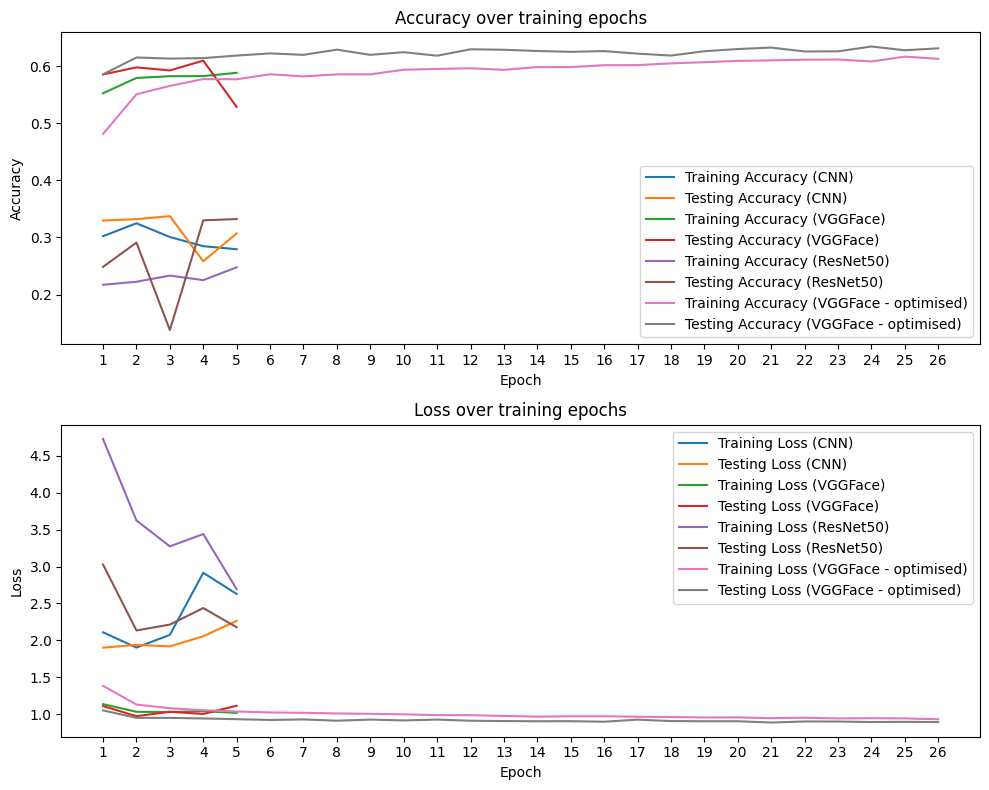

In [101]:
# Set figure size.
fig, axes = plt.subplots(nrows=2, figsize=(10,8))

# Generate line plot of training, testing loss over epochs.
# Accuracy
axes[0].plot(train_acc_cnn, label='Training Accuracy (CNN)')
axes[0].plot(test_acc_cnn, label='Testing Accuracy (CNN)')
axes[0].plot(train_acc_vgg, label='Training Accuracy (VGGFace)')
axes[0].plot(test_acc_vgg, label='Testing Accuracy (VGGFace)')
axes[0].plot(train_acc_resnet, label='Training Accuracy (ResNet50)')
axes[0].plot(test_acc_resnet, label='Testing Accuracy (ResNet50)')
axes[0].plot(train_acc_vgg_opt, label='Training Accuracy (VGGFace - optimised)')
axes[0].plot(test_acc_vgg_opt, label='Testing Accuracy (VGGFace - optimised)')

axes[0].set_title("Accuracy over training epochs")
axes[0].legend();
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(np.arange(len(test_acc_vgg_opt)), np.arange(1, len(test_acc_vgg_opt)+1))

# Loss
axes[1].plot(train_loss_cnn, label='Training Loss (CNN)')
axes[1].plot(test_loss_cnn, label='Testing Loss (CNN)')
axes[1].plot(train_loss_vgg, label='Training Loss (VGGFace)')
axes[1].plot(test_loss_vgg, label='Testing Loss (VGGFace)')
axes[1].plot(train_loss_resnet, label='Training Loss (ResNet50)')
axes[1].plot(test_loss_resnet, label='Testing Loss (ResNet50)')
axes[1].plot(train_loss_vgg_opt, label='Training Loss (VGGFace - optimised)')
axes[1].plot(test_loss_vgg_opt, label='Testing Loss (VGGFace - optimised)')

axes[1].set_title("Loss over training epochs")
axes[1].legend();
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_xticks(np.arange(len(test_acc_vgg_opt)), np.arange(1, len(test_acc_vgg_opt)+1))

# Set title 
plt.tight_layout()
plt.show()

##### Based on the plot above, the tuned VGGFace model demonstrates the best performance with the highest accuracy and lowest loss.

##### Extending the training from 5 to 26 epochs further improved the model's performance.

---

##### We further evaluate the model with other metrics.

In [67]:
# Classification Report (including precision, recall)
print(classification_report(df_test.age_range, df_test.age_predict))

              precision    recall  f1-score   support

        0-10       0.90      0.95      0.92       623
       11-20       0.68      0.39      0.50       328
       21-30       0.73      0.79      0.76      1557
       31-40       0.44      0.49      0.46       820
       41-50       0.41      0.25      0.31       444
       51-60       0.48      0.65      0.55       470
       61-70       0.42      0.29      0.34       223
      71-120       0.72      0.64      0.68       261

    accuracy                           0.63      4726
   macro avg       0.60      0.55      0.56      4726
weighted avg       0.63      0.63      0.62      4726



##### The classification results for age are lower in accuracy, precision, recall, and F1 score compared to the previous Gender and Race models. This is likely due to the inherent difficulty of accurately determining age solely from facial features. 

##### Unlike Gender and Race, which are often readily apparent from facial characteristics, age estimation is more challenging because some individuals appear younger or older than their actual age.  

##### This inherent variability represents a limitation of current age classification models.

<img src="https://miro.medium.com/v2/format:webp/0*-oGC3SE8sPCPdmxs.jpg">

##### The weighted averages for accuracy, F1 score, recall, and precision all fall within the range of 0.62 to 0.63. Please refer to the attached table for further understanding.

### 4.2 Confusion Matrix

##### Plotting the confusion matrix for validation data below:

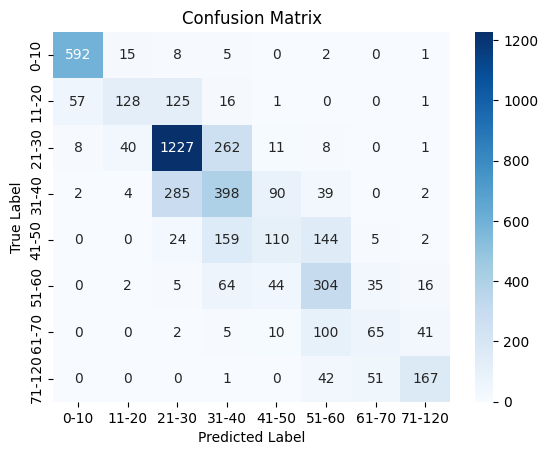

In [83]:
# Calculate the confusion matrix
cm = confusion_matrix(df_test.age_range.map(train_data.class_indices), df_test.age_predict.map(train_data.class_indices)) 

# Create a heatmap using Seaborn 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_data.class_indices.keys(), yticklabels=train_data.class_indices.keys()) # 'fmt='d' shows values as integers

# Labels, title, and ticks
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

##### The confusion matrix indicates that the majority of predictions across all age groups are correct. The model performs best with the '21-30' age group.

### 4.3 Validation image with true and false prediction

##### To gain visual insight into the predictions, refer to the random sample of true and false prediction images below.

##### - True Prediction

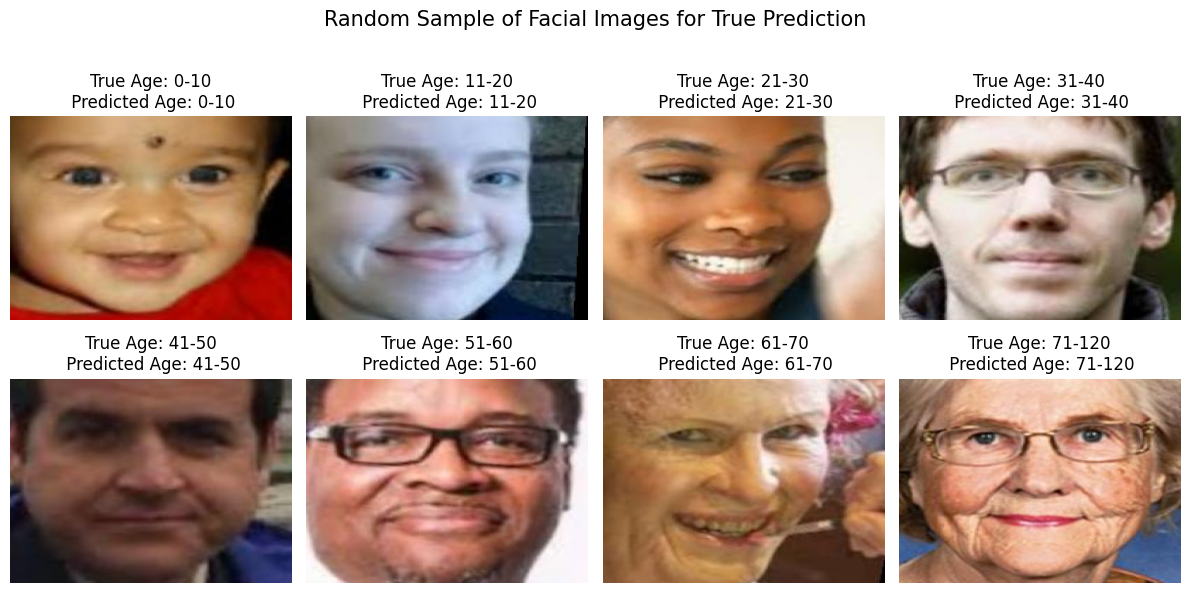

In [118]:
# set a random seed
np.random.seed(40)

# set a subplot
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

#randonly choose 8 images from correct prediction
img_list = []
for sample in ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-120']:
    for _ in range(1):
        img_list.append(np.random.choice(df_test[(df_test.age_range == df_test.age_predict) & (df_test.age_range == sample)].filename))

# Load the image
nrow = 0
ncol = 0

for num, img in enumerate(img_list):
    image = imread(os.path.join("../datasets/utkface",img))

    # Display the image
    axes[nrow, ncol].imshow(image, cmap='gray', aspect='auto')
    axes[nrow, ncol].set_title(f"True Age: {df_test.loc[df_test.filename == img].age_range.values[0]}\n Predicted Age: {df_test.loc[df_test.filename == img].age_predict.values[0]}")
    axes[nrow, ncol].axis('off')

    ncol += 1
    if ncol == 4:
        nrow += 1
        ncol = 0

plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.suptitle("Random Sample of Facial Images for True Prediction",fontsize=15)
plt.show()

##### - False prediction

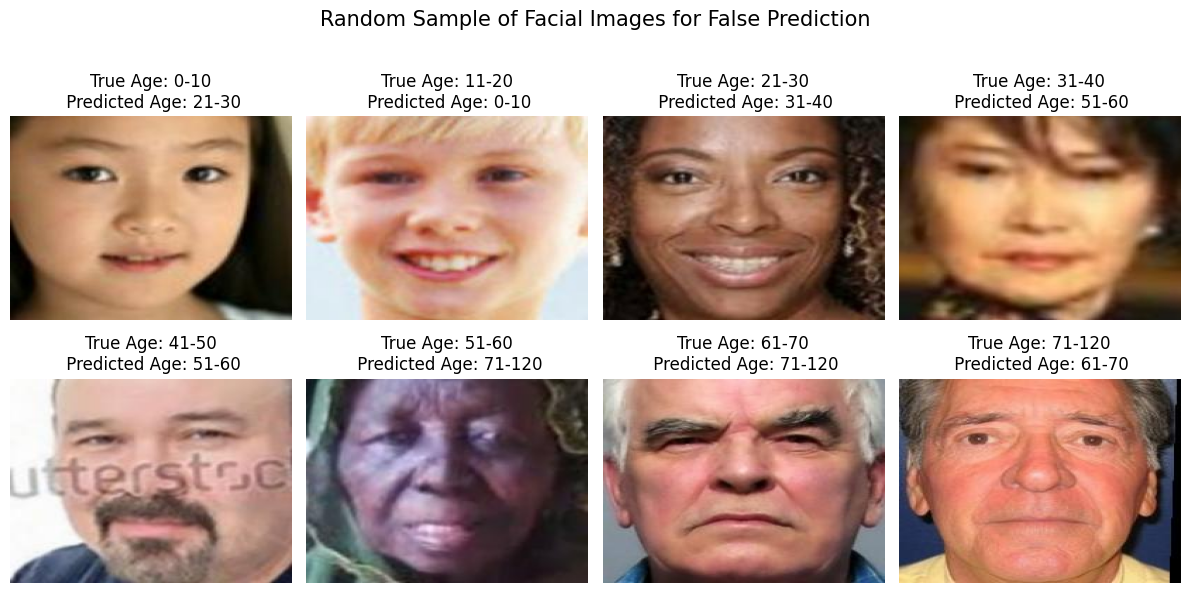

In [117]:
# set a random seed
np.random.seed(40)

# set a subplot
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

#randonly choose 8 images from incorrect prediction
img_list = []
for sample in ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-120']:
    for _ in range(1):
        img_list.append(np.random.choice(df_test[(df_test.age_range != df_test.age_predict) & (df_test.age_range == sample)].filename))

# Load the image
nrow = 0
ncol = 0

for num, img in enumerate(img_list):
    image = imread(os.path.join("../datasets/utkface",img))

    # Display the image
    axes[nrow, ncol].imshow(image, cmap='gray', aspect='auto')
    axes[nrow, ncol].set_title(f"True Age: {df_test.loc[df_test.filename == img].age_range.values[0]}\n Predicted Age: {df_test.loc[df_test.filename == img].age_predict.values[0]}")
    axes[nrow, ncol].axis('off')

    ncol += 1
    if ncol == 4:
        nrow += 1
        ncol = 0

plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.suptitle("Random Sample of Facial Images for False Prediction",fontsize=15)
plt.show()

##### The prediction images reinforce the inherent difficulty of accurately determining age based solely on facial features. Despite this challenge, the model has achieved a satisfactory level of accuracy. Therefore, I will use it as the final model for age group classification.

---

##### Next, I will move to Notebook 3.0 to build a model for face detection that incorporates all three predictive models (gender, race, and age).